In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.io

# Multi-class classification

In [2]:
data1=scipy.io.loadmat('data/ex3data1.mat')

In [3]:
X=data1['X']
X=np.insert(X,0,1,axis=1)
y=data1['y']

In [56]:
print 'X shape: %s' % str(X.shape)
print 'y shape: %s' % str(y.shape)

y_unique, y_counts = np.unique(y, return_counts=True)

print 'y unique elements: %s' % str(y_unique)
print 'y counts elements: %s' % str(y_counts)

X shape: (5000, 401)
y shape: (5000, 1)
y unique elements: [ 1  2  3  4  5  6  7  8  9 10]
y counts elements: [500 500 500 500 500 500 500 500 500 500]


In [5]:
indices = np.random.permutation(len(X))

X_train = X[indices[:int(.9 * len(X))]]
y_train = y[indices[:int(.9 * len(y))]]

X_test = X[indices[int(.9 * len(X)):]]
y_test = y[indices[int(.9 * len(y)):]]

In [6]:
print X_train.shape
print X_test.shape

(4500, 401)
(500, 401)


### Visualise the dataset

### Visualise the dataset

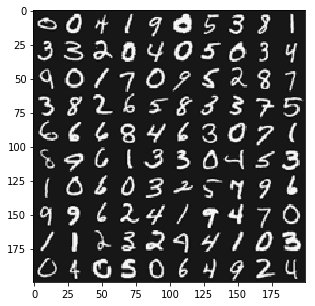

In [7]:
# random select 100 sample from X and draw and image
def display_data_set(X):
    
    nrows, ncols = 10, 10
    w, h = 20, 20
    
    random.seed(123)
    Xsel=X[random.sample(range(X.shape[0]), nrows*ncols)]
    
    img = np.zeros((w*nrows,h*ncols))
    count = 0
    
    for i in range(nrows):
        for j in range(ncols):
            #print i*h,(i+1)*h,j*w,(j+1)*w
            img[i*h:(i+1)*h,j*w:(j+1)*w] = Xsel[count,1:].reshape(w,h).T
            count += 1
            
    plt.imshow(img,cmap = cm.Greys_r)
 
plt.figure( figsize=(5,5))
display_data_set(X)
plt.show()

### Vectorizing logistic regression

In [8]:
from scipy.special import expit #Vectorized sigmoid function

def h(t_, x_):
    # t_      : [n_features, 1]
    # x_      : [n_sample, n_features]
    # return  : [n_sample, 1]
    return expit(np.dot(x_, t_))

def cost_function(t_, x_, y_, l_ = 0.):
    # t_      : [n_features, 1]
    # x_      : [n_samples, n_features]
    # y_      : [n_sample, 1]
    # l_      : 1
    # return  : 1
    m = x_.shape[0]   
    term1 = np.dot(-y_.T, np.log(h(t_,x_))) # [n_sample,1].T * [n_sample,1  = [1,1]
    term1 -= np.dot( (1-y_).T, np.log(1-h(t_,x_)) ) # [n_sample, 1].T * [n_sample,1  = [1,1]
    term1 *= 1/(1.*m)
    term2 = np.dot(t_.T, t_) # [n_feature,1].T * [n_feature,1] = [1]
    term2 *= l_/(2.*m)
    
    return (term1 + term2) # [1]
    
def cost_gradient(t_, x_, y_, l_ = 0.):
    # t_      : [n_features, 1]
    # x_      : [n_samples, n_features]
    # y_      : [n_sample, 1]
    # return  : [n_feature, ]    
    m = x_.shape[0]
    
    hh = np.expand_dims(h(t_, x_),axis=1)
        
    grad = np.dot(x_.T, hh - y_) # [n_sample, n_feature].T * [n_sample, 1] = [n_feature,1]
    grad *= 1/(1.*m)
            
    t_ = np.expand_dims(t_,axis=1)
      
    grad[1:] += t_[1:]*l_/(1.*m)
    
    return grad.reshape(-1)

### Minimization rutines 

In [9]:
from scipy import optimize

def minimize_cost(t_,x_,y_,l_=0.,maxit=100):

    result = optimize.fmin_cg(cost_function, fprime=cost_gradient, x0=t_, \
                              args=(x_, y_, l_), maxiter=maxit, disp=False,\
                              full_output=True)
    
    return result[0], result[1]

### One-vs-all classification

In [10]:
%%time
Theta = np.zeros((10,X.shape[1]))
for i in xrange(10): 
    iclass = i if i else 10
    #theta_init = np.zeros((X.shape[1],1)).reshape(-1)
    theta_init = np.random.rand(X.shape[1],1).reshape(-1)
    theta, cost = minimize_cost(theta_init, X, (y == iclass).astype(int), l_=0.,maxit=50) 
    print "Optimize for handwritten digit %d, cost = %.2f" % (iclass, cost) 
    Theta[i:,] = theta.T

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


Optimize for handwritten digit 10, cost = 0.00
Optimize for handwritten digit 1, cost = 0.01
Optimize for handwritten digit 2, cost = 0.06
Optimize for handwritten digit 3, cost = 0.06
Optimize for handwritten digit 4, cost = 0.04
Optimize for handwritten digit 5, cost = 0.06
Optimize for handwritten digit 6, cost = 0.02
Optimize for handwritten digit 7, cost = 0.03
Optimize for handwritten digit 8, cost = 0.08
Optimize for handwritten digit 9, cost = 0.08
CPU times: user 6.32 s, sys: 182 ms, total: 6.5 s
Wall time: 4.11 s


### Evaluate results

In [11]:
def predict(T_, x_):
    classes = [10] + range(1,10)
    prob = [0]*10
    for i in xrange(10):
        prob[i] = h(T_[i], x_)
    return classes[np.argmax(np.array(prob))],prob      

In [67]:
ncorrect = 0.
ntot = len(X)

incorrect_indeces = []
correct_counter = [0]*10

for i in xrange(len(X)):

    pred, prob = predict(Theta, X[i])
    
    if pred == int(y[i]):
        ncorrect += 1
        correct_counter[ int(y[i]) if int(y[i]) != 10 else 0 ] += 1
    else:
        incorrect_indeces.append(i)
        
print 'Classification accuracy: %.2f %%' % float(100*ncorrect/ntot)
print 'Accuracy by class: ', 100*(correct_counter/y_counts.astype('float'))

Classification accuracy: 95.22 %
Accuracy by class:  [ 99.6  99.2  93.2  92.2  96.   92.6  98.4  96.   93.2  91.8]


Classification for digit 0, 1 and 6 are suspiciously high, while it is quite low for digit 8...

### Display some misclassified sample

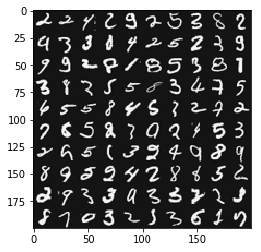

In [13]:
display_data_set(X[incorrect_indeces])
plt.show()

### Validate model with scikit-learn linear regression implementation

In [14]:
from sklearn import linear_model  
logi=linear_model.LogisticRegression(multi_class='ovr', C=1)
logi.fit(X_train,y_train.reshape(-1))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [15]:
pred = logi.predict(X)
correct_counter = [0]*10

for i in range(len(pred)):
    if pred[i] == y[i,0]:
        correct_counter[ y[i,0] if y[i,0] != 10 else 0 ] += 1

print 'Scikit-learn classification accuracy: %.2f %%' % float(100*logi.score(X,y.reshape(-1)))
print 'Scikit-learn accuracy by class: ', np.array(correct_counter)/500.

Scikit-learn classification accuracy: 94.28 %
Scikit-learn accuracy by class:  [ 0.994  0.984  0.908  0.92   0.948  0.91   0.974  0.948  0.926  0.916]


# Neural Network

In [16]:
data1=scipy.io.loadmat('data/ex3weights.mat')

In [17]:
Theta1 = data1['Theta1']
Theta2 = data1['Theta2']

In [18]:
print X.shape
print Theta1.shape
print Theta2.shape

(5000, 401)
(25, 401)
(10, 26)


Add column of 1's to Theta1

In [19]:
Theta1=np.insert(Theta1,0,1,axis=0)
print Theta1.shape

(26, 401)


### Feed-forward propagation

In [62]:
def feed_forward(x_, thetas_):
    ll = x_
    for t_ in thetas_:
        ll = expit(t_.dot(ll)) # First layer activation
    return ll

def prediction(x_,thetas_):
    classes = range(1,10) + [10]
    
    prob=feed_forward(x_, thetas_)
    return classes[prob.argmax()],prob 

def test(x_,thetas_, y_):
    
    correct_counter = [0]*10
    n_correct, n_total = 0. , 0.
    incorrect_indices = []
    
    for i in xrange(len(X)):
        n_total += 1
        pred, prob = prediction(X[i], thetas_)
        
        if pred == y[i,0]:
            n_correct += 1
            correct_counter[ y[i,0] if y[i,0] != 10 else 0 ] += 1

        else: incorrect_indices.append(i)
            
    return n_correct/n_total, correct_counter/y_counts.astype('float'), incorrect_indices
            

In [58]:
feed_forward(X[0], [Theta1, Theta2])

array([  1.12661530e-04,   1.74127856e-03,   2.52696959e-03,
         1.84032321e-05,   9.36263860e-03,   3.99270267e-03,
         5.51517524e-03,   4.01468105e-04,   6.48072305e-03,
         9.95734012e-01])

In [59]:
prediction(X[89], [Theta1, Theta2]), y[89]

((10, array([  5.22650342e-04,   3.73613410e-02,   1.85398558e-03,
           2.65322294e-03,   1.35586695e-02,   1.04265787e-03,
           2.48823039e-03,   1.23925708e-03,   5.61718279e-03,
           5.76632079e-01])), array([10], dtype=uint8))

### Evaluate results

In [63]:
accu, correct_counter, incorrect_indices = test(X, [Theta1, Theta2], y)
print 'Classification accuracy: %.1f %%' % (100.*accu)
print 'Accuracy by class: ', (100*correct_counter)

Classification accuracy: 97.5 %
Accuracy by class:  [ 99.2  98.2  97.   96.   96.8  98.4  98.6  97.   98.2  95.8]


### Display some misclassified sample

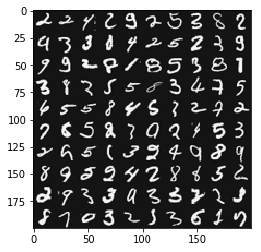

In [24]:
display_data_set(X[incorrect_indeces])
plt.show()